In [43]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter
from skimage.restoration import denoise_tv_chambolle
import numpy as np
from skimage.transform import resize
import pickle 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset


In [44]:
fichier_keys = '/Users/jeremytournellec/Desktop/test2/OAS1_0002_MR1_mpr_nn_anon_111_t88_masked_gfc copie.key'
fichier_image = '/Users/jeremytournellec/Desktop/test2/OAS1_0002_MR1_mpr_nn_anon_111_t88_masked_gfc copie.hdr'


In [45]:
def open_image(fichier_image):
    Nifti_img = nib.load(fichier_image)
    data = np.squeeze(Nifti_img.get_fdata())
    return data

Extraction des keypoints des differentes images à partir des .keys

In [46]:
def extract_keypoints_descriptors(adresse_kp, image):
    with open(adresse_kp, "r") as fichier:
        lignes = fichier.readlines()

    image = open_image(fichier_image)

# Définir les motifs à ne pas afficher
    motifs_a_ignorer = [
    "# featExtract 1.1",
    "# Extraction Voxel Resolution (ijk)",
    "# Extraction Voxel Size (mm)  (ijk)",
    "# Feature Coordinate Space",
    "Features:",
    "Scale-space location"
]

# Afficher uniquement les lignes qui ne correspondent pas aux motifs à ignorer
    xs = []
    ys = []
    zs = []
    scales = []
    descripteurs = []
    patchs = []


    for ligne in lignes:
        if not any(ligne.strip().startswith(motif) for motif in motifs_a_ignorer):
            elements = ligne.strip().split()
            #print(elements)
            x = int(float(elements[0]))
            y = int(float(elements[1]))
            z = int(float(elements[2]))
            scale = int(float(elements[3]))
            desc = np.array(elements[18:82], dtype=np.float32)
            patch = image[max(x-scale, 0):x+scale, max(y-scale, 0):y+scale,
                      max(z-scale, 0):z+scale]
            xs.append(x)
            ys.append(y)
            zs.append(z)
            scales.append(scale)
            patchs.append(patch)
            descripteurs.append(desc)
    return xs, ys, zs, scales, patchs, descripteurs

    

In [47]:
xs, ys, zs, scales, patchs, descripteurs = extract_keypoints_descriptors(fichier_keys, fichier_image)

In [48]:
print(patchs[7].shape)

(6, 6, 6)


In [49]:

def generate_lien__image_bdd(k):
    data_image = f'/Users/jeremytournellec/Desktop/images/OAS1_{k:04}_MR1_mpr_nn_anon_111_t88_masked_gfc.hdr'
    data_descripteurs = f'/Users/jeremytournellec/Desktop/labels/OAS1_{k:04}_MR1_mpr_nn_anon_111_t88_masked_gfc.key'
    #OAS1_0002_MR1_mpr_nn_anon_111_t88_masked_gfc.key

    return data_image, data_descripteurs


construction de la database de keypoints et de leurs descriptors (retourne un dictionnaire)

In [50]:
def build_database():
    compteur_absent = 0
    database = {'xs': [], 'ys': [], 'zs': [], 'scales': [], 'descriptors': [], 'patchs': []}
    for k in range(1, 399):
        data_image, data_descripteurs = generate_lien__image_bdd(k)
        try:
                xs, ys, zs, scales, patchs, descripteurs = extract_keypoints_descriptors(data_descripteurs, data_image)
        except Exception as e:
            print(f"Erreur pas présent dans la BDD")
            compteur_absent +=1
            continue
        database['xs'].extend(xs)
        database['ys'].extend(xs)
        database['zs'].extend(xs)
        database['zs'].extend(xs)
        database['descriptors'].extend(descripteurs)
        database['scales'].extend(scales)
        database['patchs'].extend(patchs)
    database['descriptors'] = np.array(database['descriptors'], dtype=np.float32)

    #print(compteur_absent)
    return database

    
# Exemple d'images pour la base de données

database = build_database()

Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur pas présent dans la BDD
Erreur p

In [51]:
print(database['scales'])

[4, 4, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 4, 3, 4, 3, 4, 

KNN

In [52]:
knn = NearestNeighbors(n_neighbors=1, algorithm='auto')
knn.fit(database['descriptors'])

#enregistrement du knn pour l'utiliser quand on veut

knnPickle = open('knnpickle_file', 'wb') 
pickle.dump(knn, knnPickle)  
knnPickle.close()

génération d'une image aléatoire avec alea_generator_image_test() puis reconstruction avec reconstruct_image(data_descripteurs_test, data_image_test, knn) à partir du knn et de la database puis affichage d'une coupe 2D

In [56]:
import random

def alea_generator_image_test():

    number = random.randint(400, 416)
    data_image_test, data_descripteurs_test = generate_lien__image_bdd(number)

    return data_image_test, data_descripteurs_test
    

In [57]:
data_image_test, data_descripteurs_test = alea_generator_image_test()

In [58]:
knn = pickle.load(open('knnpickle_file', 'rb'))

In [59]:
def reconstruct_image(data_descripteurs_test, data_image_test, knn):
    liste_x = []
    xs, ys, zs, scales, patchs, descripteurs = extract_keypoints_descriptors(data_descripteurs_test, data_image_test)
    data_image = open_image(fichier_image)
    reconstructed_image = np.zeros_like(data_image)

    for x, y, z, scale, descripteur in zip(xs,ys, zs, scales, descripteurs):
        _, idx = knn.kneighbors([descripteur])
        closest_x = database['xs'][idx[0][0]]
        closest_y = database['ys'][idx[0][0]]
        closest_z = database['zs'][idx[0][0]]
        closest_scale = database['scales'][idx[0][0]]
        closest_patch = database['patchs'][idx[0][0]]
        liste_x.append(x)
        #print(closest_patch.shape)
        #print(reconstructed_image.shape)
        

        
        y_start = max(y-closest_scale, 0)
        y_end = min(y+closest_scale, 208) #pour pas que ça dépasse de la taille de l'image

        x_start = max(x - closest_scale, 0)
        x_end = min(x + closest_scale, 176)

        z_start = max(z - closest_scale, 0)
        z_end = min(z + closest_scale, 176)

        #best_patch_bdd_resized = resize(best_patch_bdd, (y_end - y_start, x_end - x_start, z_end - z_start))
        #reconstructed_image[x_start:x_end, y_start:y_end, z_start:z_end] = closest_patch


        resized_patch = resize(closest_patch, (y_end - y_start, x_end - x_start, z_end - z_start))
        reconstructed_image[x_start:x_end, y_start:y_end, z_start:z_end] = resized_patch

    #reconstructed_image = fill_missing_pixels(reconstructed_image)
    #reconstructed_image = fill_missing_pixels_with_diffusion(reconstructed_image)


    #print(len(liste_x))

    return reconstructed_image


In [24]:
reconstructed_image = reconstruct_image(data_descripteurs_test, data_image_test, knn)

In [60]:
reconstructed_image.shape

(176, 208, 176)

In [61]:
slice_2d = reconstructed_image[:, :, reconstructed_image.shape[2] // 2]

slice_2d.shape

(176, 208)

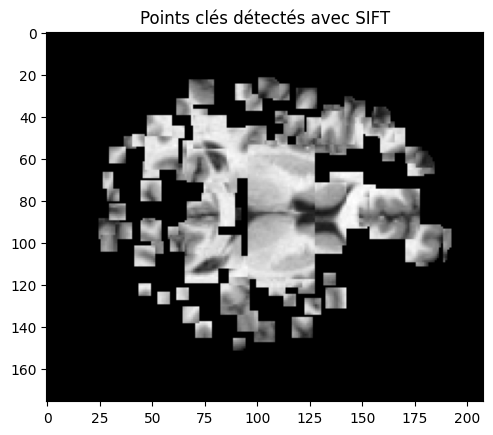

In [62]:
slice_2d = reconstructed_image[:, :, reconstructed_image.shape[2] // 2]
plt.imshow(slice_2d, cmap='gray')
plt.title("Points clés détectés avec SIFT")
plt.show()

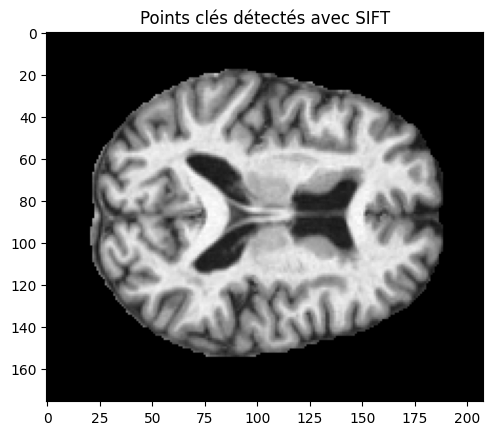

In [28]:
data = open_image(data_image_test)
slice_2d = data[:, :, data.shape[2] // 2]
plt.imshow(slice_2d, cmap='gray')
plt.title("Points clés détectés avec SIFT")
plt.show()

generation des tensors

Suite à ça on peut s'amuser à utiliser un VAE comme RESNET pour regénérer au mieux le cerveau. L'image d'entrée étant le cerveau reconstruit avec le base de données et la cible étant le cerveau de référence.
On fournit au réseau uniquement des coupes 2D donc la reconstruction sera une image 2D par soucis de simplicité

In [63]:



def generate_tensors(start, end, type):
    liste_reconstructed_images = []
    liste_true_images = []
    for k in range(start, end):
        data_image, data_descripteurs = generate_lien__image_bdd(k)
        try:
            true_image_3D = open_image(fichier_image)
            true_image_2D = true_image_3D[:, :, true_image_3D.shape[2] // 2]
            reconstructed_image_3D = reconstruct_image(data_descripteurs, data_image, knn)
            reconstructed_image_2D = reconstructed_image_3D[:, :, reconstructed_image_3D.shape[2] // 2]
            true_image_2D = true_image_3D[:, :, true_image_3D.shape[2] // 2]
            liste_reconstructed_images.append(reconstructed_image_2D)
            liste_true_images.append(true_image_2D)
            print(f'{k}/416')
        except Exception as e :
            print('pas dans la base de données !')
            continue
    tensor_x = torch.Tensor(liste_reconstructed_images)
    tensor_y = torch.Tensor(liste_true_images)
    #tf_tensor_x = tf.convert_to_tensor(liste_reconstructed_images)
    #tf_tensor_y = tf.convert_to_tensor(liste_true_images)

    #numpy_tensor_x = liste_reconstructed_images.numpy()
    #numpy_tensor_y = liste_true_images.numpy()

    #np.save("tf_tensor_x.npy", numpy_tensor_x)
    #np.save("tf_tensor_y.npy", numpy_tensor_y)

    torch.save(tensor_x, f'tensor_x_{type}.pt')
    torch.save(tensor_y, f'tensor_y_{type}.pt')

   # my_dataset = TensorDataset(tensor_x,tensor_y) 
    #my_dataloader = DataLoader(my_dataset) 
    
    #with open("reconstructed", "w") as f:
       # json.dump(liste_reconstructed_images, f)

   # with open("true", "w") as f:
       # json.dump(liste_true_images, f)

    return tensor_x,  tensor_y

In [26]:
#NE PAS RUN CETTE CELLULE !!!

#type peut être 'train' ou 'test'
train_tensor_x,  test_tensor_y = generate_tensors(1, 399, 'train')

1/416
2/416
3/416
4/416
5/416
6/416
7/416
pas dans la base de données !
9/416
10/416
11/416
12/416
13/416
14/416
15/416
16/416
17/416
18/416
19/416
20/416
21/416
22/416
23/416
pas dans la base de données !
25/416
26/416
27/416
28/416
29/416
30/416
31/416
32/416
33/416
34/416
35/416
pas dans la base de données !
37/416
38/416
39/416
40/416
41/416
42/416
43/416
44/416
45/416
46/416
47/416
pas dans la base de données !
49/416
50/416
51/416
52/416
53/416
54/416
55/416
56/416
57/416
58/416
59/416
60/416
61/416
62/416
63/416
64/416
65/416
66/416
67/416
68/416
69/416
70/416
71/416
72/416
73/416
74/416
75/416
76/416
77/416
78/416
79/416
80/416
81/416
82/416
83/416
84/416
85/416
86/416
87/416
88/416
pas dans la base de données !
90/416
91/416
92/416
pas dans la base de données !
94/416
95/416
96/416
97/416
98/416
99/416
pas dans la base de données !
101/416
102/416
103/416
104/416
105/416
106/416
107/416
108/416
109/416
110/416
111/416
112/416
113/416
114/416
115/416
116/416
117/416
pas dans la

/var/folders/t_/qn4dqp2s7kn4_b4mzs5z94_m0000gn/T/ipykernel_63315/2148234160.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  tensor_x = torch.Tensor(liste_reconstructed_images)


In [27]:
#NE PAS RUN CETTE CELLULE !!!

test_tensor_x,  test_tensor_y = generate_tensors(400, 415, 'test')

400/416
401/416
402/416
403/416
404/416
405/416
406/416
407/416
408/416
409/416
410/416
411/416
pas dans la base de données !
413/416
pas dans la base de données !


In [64]:
train_tensor_x = torch.load('tensor_x_train.pt')
train_tensor_y = torch.load('tensor_y_train.pt')
train_dataset = TensorDataset(train_tensor_x, train_tensor_y) 
train_dataloader = DataLoader(train_dataset) 

test_tensor_x = torch.load('tensor_x_test.pt')
test_tensor_y = torch.load('tensor_y_test.pt')
test_dataset = TensorDataset(train_tensor_x, train_tensor_y) 
test_dataloader = DataLoader(train_dataset) 

/var/folders/t_/qn4dqp2s7kn4_b4mzs5z94_m0000gn/T/ipykernel_1041/3612539905.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_tensor_x = torch.load('tensor_x_train.pt

In [65]:
test_tensor_x.shape
test_tensor_y.shape

torch.Size([13, 176, 208])

In [66]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encodeur
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Couche centrale
        self.center = self.conv_block(512, 1024)

        # Décodeur
        self.dec4 = self.upconv_block(1024, 512)
        self.dec3 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(256, 128)
        self.dec1 = self.upconv_block(128, 64)

        # Couche de sortie
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), #deux convolutions consécutives à chaque fois 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encodeur
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Couche centrale
        center = self.center(enc4)

        # Décodeur
        dec4 = self.dec4(center)
        dec3 = self.dec3(dec4)
        dec2 = self.dec2(dec3)  
        dec1 = self.dec1(dec2)  

        # Sortie
        out = self.final_conv(dec1) 
        return out


In [47]:
        #dec4 = self.dec4(center)
        #dec3 = self.dec3(dec4 + enc4)  # skip connection
        #dec2 = self.dec2(dec3 + enc3)  # skip connection
        #dec1 = self.dec1(dec2 + enc2)

In [67]:
def train_test_model(model, train_loader, test_loader, criterion, optimizer, epochs=2):
    all_train_loss = []
    all_test_loss = []
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to('mps'), targets.to('mps')

            # Mise à zéro des gradients
            optimizer.zero_grad()

            # Passage avant
            outputs = model(inputs)
            #print(f"outputs shape: {outputs.shape}")
            #print(f"targets shape: {targets.shape}")        

            # Calcul de la perte
            loss = criterion(outputs, targets)

            # Rétropropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss_div = running_loss/len(train_loader)
        all_train_loss.append(running_loss_div)


        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets =inputs.to('mps'), targets.to('mps')

                outputs = model(inputs)
                loss2 = criterion(outputs, targets)
                test_loss +=loss2.item()
            test_loss_div = test_loss/len(test_loader)
            all_test_loss.append(test_loss_div)







        print(f"Epoch {epoch+1}, train loss: {running_loss/len(train_loader)}, test loss: {test_loss/len(test_loader)}")

    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_test_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

Epoch 1, train loss: 62318.98815140236, test loss: 39614.39290274411
Epoch 2, train loss: 36365.27695961738, test loss: 32530.834714768007
Epoch 3, train loss: 32309.004539257272, test loss: 29587.640484331718
Epoch 4, train loss: 30448.25533186894, test loss: 27971.967703103357
Epoch 5, train loss: 29270.041602644564, test loss: 27236.22164452043
Epoch 6, train loss: 28480.088480349725, test loss: 26805.124975653565
Epoch 7, train loss: 27882.522450116863, test loss: 26500.534607102665
Modèle sauvegardé.


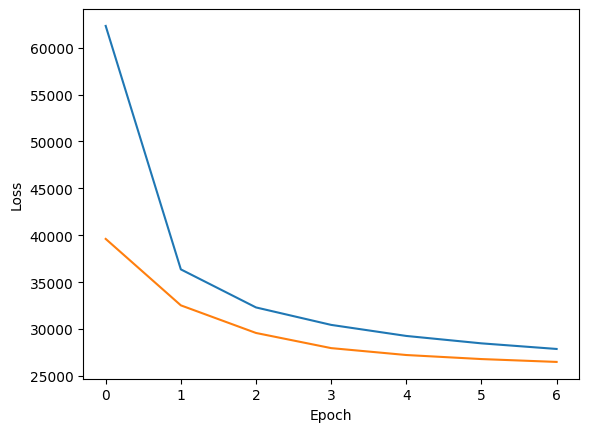

In [7]:
#prend environ 55min/epoch

model = UNet(in_channels=1, out_channels=1).to('mps')  # Déplacer le modèle sur le GPU
criterion = nn.MSELoss()  # Erreur quadratique moyenne pour la reconstruction
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Entraîner le modèle
train_test_model(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=7)

# Sauvegarder le modèle après l'entraînement
torch.save(model.state_dict(), "unet_model.pth")
print("Modèle sauvegardé.")



In [ ]:
train_tensor_x = torch.load('tensor_x_train.pt')
train_tensor_y = torch.load('tensor_y_train.pt')
train_dataset = TensorDataset(train_tensor_x, train_tensor_y) 
train_dataloader = DataLoader(train_dataset) 

test_tensor_x = torch.load('tensor_x_test.pt')
test_tensor_y = torch.load('tensor_y_test.pt')
test_dataset = TensorDataset(train_tensor_x, train_tensor_y) 
test_dataloader = DataLoader(train_dataset) 

In [ ]:
model = UNet(in_channels=1, out_channels=1).to('mps')  # Déplacer le modèle sur le GPU
criterion = nn.MSELoss()  # Erreur quadratique moyenne pour la reconstruction
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Entraîner le modèle
train_test_model(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=7)

# Sauvegarder le modèle après l'entraînement
torch.save(model.state_dict(), "unet_model.pth")
print("Modèle sauvegardé.")

**Evaluation des resultats finaux**

In [68]:
#pour afficher une image

def return_result_loss(data_image, data_descripteurs):
    reconstructed_image_3D = reconstruct_image(data_descripteurs, data_image, knn)
    reconstructed_image_2D = torch.Tensor(reconstructed_image_3D[:, :, reconstructed_image_3D.shape[2] // 2]).unsqueeze(0)
    reconstructed_image_2D = reconstructed_image_2D.to('mps')


    out = model(reconstructed_image_2D)
    #out est un tensor, il faut le repasser sur une image
    output_array = out.detach().cpu().numpy()
    output_image = output_array.squeeze(0)  # Supprimer les dimensions inutiles (batch et canaux)
  


    data_reelle = open_image(data_image)
    slice_2d_reelle = data_reelle[:, :, data_reelle.shape[2] // 2]

    

    loss_bdd = int(criterion(torch.Tensor(reconstructed_image_2D).cpu(), torch.Tensor(slice_2d_reelle).cpu()).item())
    loss_bdd_UNET = int(criterion(torch.Tensor(output_image).cpu(), torch.Tensor(slice_2d_reelle).cpu()).item())

    reconstructed_image_2D = reconstructed_image_2D.cpu().squeeze(0)

    return slice_2d_reelle, reconstructed_image_2D, output_image, loss_bdd, loss_bdd_UNET



In [69]:
def plot_resultats():

    data_image_test, data_descripteurs_test = alea_generator_image_test()

    slice_2d_reelle, reconstructed_image_2D, output_image, loss_bdd, loss_bdd_UNET = return_result_loss(data_image_test, data_descripteurs_test)


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(slice_2d_reelle, cmap='gray')
    axes[0].set_title('Image')


    axes[1].imshow(reconstructed_image_2D, cmap='gray')
    axes[1].set_title('Image reconstruite base de données')
    axes[1].text(10, 10, f' MSE : {str(loss_bdd)}', fontsize=15, color='white')


    axes[2].imshow(output_image, cmap='gray')
    axes[2].set_title('Image reconstruite avec base de données + UNET')
    axes[2].text(10, 10, f' MSE : {str(loss_bdd_UNET)}', fontsize=15, color='white')
    

In [72]:
model = UNet() 
model.load_state_dict(torch.load("unet_model.pth"))
model = model.to('mps')

/var/folders/t_/qn4dqp2s7kn4_b4mzs5z94_m0000gn/T/ipykernel_1041/361105822.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_model.pt

In [74]:
criterion = nn.MSELoss()  # Erreur quadratique moyenne pour la reconstruction
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Applications/anaconda3/envs/env_ets3/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([176, 208])) that is different to the input size (torch.Size([1, 176, 208])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


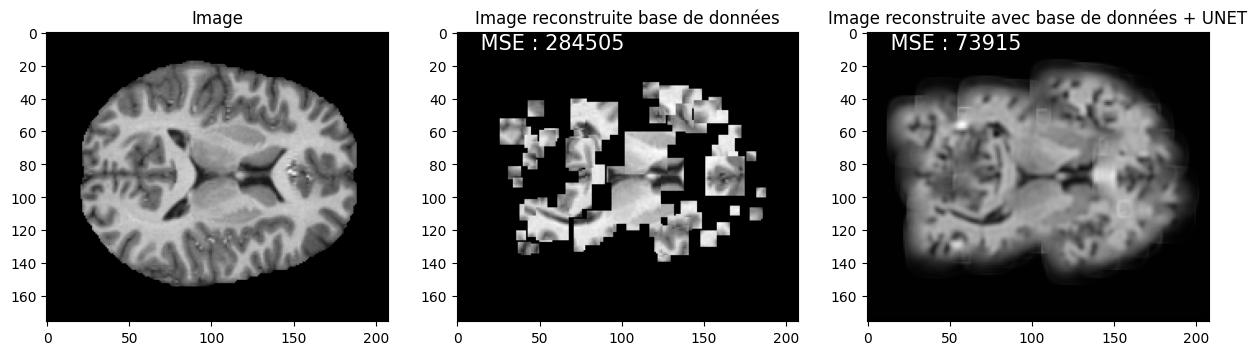

In [78]:
#pour une image test aléatoire, on affiche l'image originale, l'image reconstruite avec la BDD et les descripteurs et enfin l'image reconstruite avec la BDD et un UNET en sortie
plot_resultats()

In [49]:

loss_totale_bdd = 0
loss_total_bdd_UNET = 0
compteur = 0
for k in range(400, 415):

    data_image, data_descripteurs = generate_lien__image_bdd(k)
    try:
        slice_2d_reelle, reconstructed_image_2D, output_image, loss_bdd, loss_bdd_UNET = return_result_loss(data_image, data_descripteurs)
        loss_totale_bdd +=loss_bdd
        loss_total_bdd_UNET += loss_bdd_UNET
        compteur +=1
     
    except Exception as e:
        print('no')
        continue
    
    #print(compteur)


loss_moyenne_bdd = loss_totale_bdd/compteur
loss_moyenne_bdd_UNET = loss_total_bdd_UNET/compteur

print(f' la loss moyenne de la technique se basant sur la bdd est de : {loss_moyenne_bdd} et la loss moyenne se basant sur la bdd et le UNET est de : {loss_moyenne_bdd_UNET} ')

        

/Applications/anaconda3/envs/env_ets3/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([176, 208])) that is different to the input size (torch.Size([1, 176, 208])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Applications/anaconda3/envs/env_ets3/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([176, 208])) that is different to the input size (torch.Size([1, 176, 208])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Applications/anaconda3/envs/env_ets3/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([176, 208])) that is different to the input size (torch.Size([1, 176, 208])). This will li

no
no
 la loss moyenne de la technique se basant sur la bdd est de : 294156.6153846154 et la loss moyenne se basant sur la bdd et le UNET est de : 79062.30769230769 


/Applications/anaconda3/envs/env_ets3/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([176, 208])) that is different to the input size (torch.Size([1, 176, 208])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
